In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Model </h1>

I consider the scattering of only one photon towards a 2-level atom. Also, I assume that several atoms might be in the waveguide (to play the role of a mirror for instance). I work in the subspace :

$$ \ket{1,0}, \ket{0,1} $$

And the Hamiltonian is given by: 

$$ H = \sum_k \omega_k a_k^{\dagger} a_k + \frac{1}{2} \sum_j \Omega_j (1 + \sigma_j^z) + \sum_{k,j}\left\{g(k,j) \sigma^+ a_k + \text{h.c} \right\} $$

with $g(k,j) = i g_0 \sqrt{\omega_k} e^{ikx_j}$

<h1> Conduct time evolution </h1>

In [2]:
def get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, use_WW_approx = True, print_nb_modes = False):
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    omega_tab = np.abs(k_tab)
    n_modes = len(k_tab)
    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #tab of couplings
    g_tab = np.zeros(n_modes, dtype=complex)
    for i in range(n_modes):
        if use_WW_approx:
            g_tab[i] = g_0*np.sqrt(omega_A / L)*1j
        else:
            g_tab[i] = g_0*np.sqrt(omega_tab[i] / L)*1j #in my case, g is independant of the atom index

    #Creation of the Hamiltonian
    dim_subspace = n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    ##diagonal elements
    for i in range(n_modes):
        H_matrix[i, i] = omega_tab[i]
    H_matrix[n_modes, n_modes] = omega_A

    ##off diagonal elements
    for i in range(n_modes):
        H_matrix[n_modes, i] = g_tab[i]
        H_matrix[i,n_modes] = np.conjugate(H_matrix[n_modes,i])

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None
    #also obtain the free hamiltonian
    H_free = qt.Qobj(np.diag(np.diag(H_matrix)))

    ##Initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    x_bar = x_0

    init_state = 0
    for i in range(n_modes): ##only the modes with positive momentum are excited at the beginning
        coef = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * x_bar)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states

    #also get the free evolution of the initial state
    result_free = qt.sesolve(H_free, init_state, times, options={"nsteps":10000, "store_states": True})
    state_list_free = result_free.states
    
    #Extracting the populations of the modes and the atom
    N_k_t = np.zeros((n_modes, n_step))
    N_A_t = np.zeros(n_step)
    overlap_free_evol = np.zeros(n_step)


    print("Computing occupation numbers in momentum space...")
    for t in tqdm(range(n_step)):
        current_state = state_list[t]

        for i in range(n_modes):
            momentum_state = qt.basis(dim_subspace, i)
            N_k_t[i, t] = np.abs(momentum_state.dag() * current_state)**2

        atomic_state = qt.basis(dim_subspace, n_modes)
        N_A_t[t] += np.abs(atomic_state.dag() * current_state)**2
        
        overlap_free_evol[t] = np.abs(state_list_free[t].dag() * current_state)**2

    return times, k_tab, N_k_t, N_A_t, overlap_free_evol

<h1> First test </h1>

Check the parameters first

In [ ]:
L = 150*pi
T = L/2
dt = 0.1

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 0.1
omega_A = 3
gamma = 2*g_0**2*omega_A

#initial photon wavepacket parameters
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4
omega_0 = 2.99

#numerical implementation of momentum space
omega_max = 30*omega_A

print("Coupling g(k,j): ", g_0*np.sqrt(omega_A / L))
print("sigma_momentum: ", sigma_momentum)
print("Decay rate gamma: ", gamma)


Coupling g(k,j):  0.007978845608028654
sigma_momentum:  0.016976527263135505
Decay rate gamma:  0.06000000000000001


Now, run the function

In [22]:
times, k_tab, N_k_t, N_A_t, overlap_free_evol = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, print_nb_modes = True)

Number of modes:  8999


capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
    out = self.system.matmul_data(t, state)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized


: 

<h1> R and T coefficients </h1>

Try to define reflection and transmission cofficients ? Let me define:

$N_k = a_k^{\dagger} a_k$ and $N_x = a_x^{\dagger} a_x$ where :

$$a_x = \frac{1}{\sqrt{N}} \sum_k e^{ikx} a_k$$

I can define : 

$$P_-(t) = \sum_{k < 0} N_k \,\, , \,\, P_+(t) = \sum_{k > 0} N_k $$

It is also interesting to check that the atomic number remains close to zero :

$$ N_A = \sum_j \left(\frac{1+\sigma_j^z}{2}\right)$$

The transmission coefficient is $T = P_+(\infty)$ and the reflection is $R = P_-(\infty)$

Results from summation per modes
T =  0.20234287351150623
R =  0.7648677497550527
Final occupation of the atom =  0.03278937673344206
---------------------------------------------------------
Results from overlap
T =  0.12444688080260763
R =  0.8427637424639504
Final occupation of the atom =  0.03278937673344206


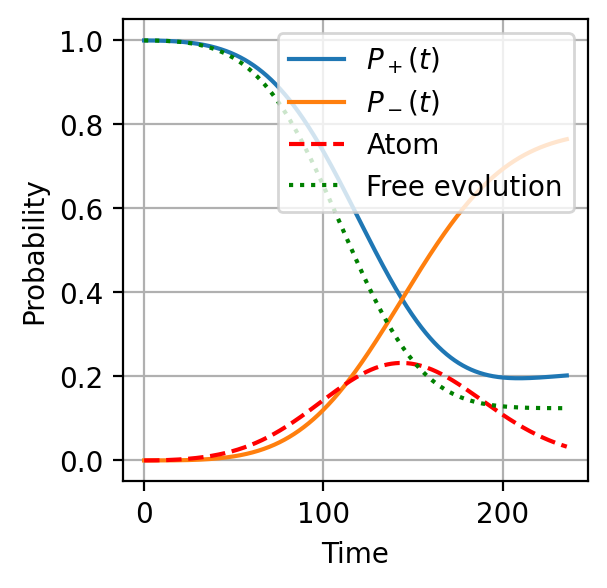

In [20]:
n_modes = N_k_t.shape[0]

nb_pts = len(times)
P_p = np.zeros(nb_pts)
P_m = np.zeros(nb_pts)

for t in range(nb_pts):
    for i in range(n_modes): 
        if k_tab[i] > 0:
            P_p[t] += N_k_t[i,t]
        else:
            P_m[t] += N_k_t[i,t]


print("Results from summation per modes")
print("T = ", P_p[-1])
print("R = ", P_m[-1])
print("Final occupation of the atom = ", N_A_t[-1])
print("---------------------------------------------------------")
print("Results from overlap")
print("T = ", overlap_free_evol[-1])
print("R = ", 1- overlap_free_evol[-1]- N_A_t[-1])
print("Final occupation of the atom = ", N_A_t[-1]) 


fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(times, P_p, label=r'$P_+(t)$')
ax.plot(times, P_m, label=r'$P_-(t)$')
#ax.plot(times, P_p+P_m, label=r'$P_+ + P_-$', linestyle='--', alpha=0.5) 
ax.plot(times, N_A_t, label='Atom', linestyle='--', color='red')   
ax.plot(times, overlap_free_evol, label='Free evolution', linestyle=':', color='green')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

<h2> Occupation number of one specific mode </h2>

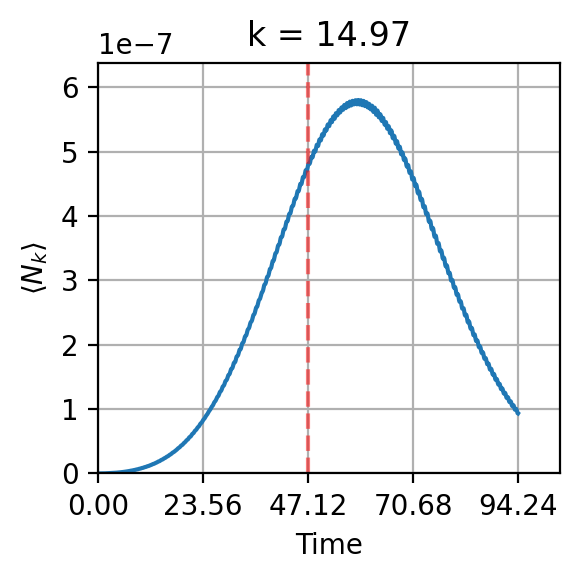

In [80]:
k_target = 6*omega_0
k_index = np.argmin(np.abs(k_tab - k_target))

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

ax.plot(times, N_k_t[k_index,:])
ax.set_xlim(0, 1.1*times[-1])
ax.set_xticks(np.floor(100*np.array([0, T/4, T/2, 3*T/4, T]))/100)
ax.set_xlabel('Time')
ax.vlines(T/2, 0, 1, color='r', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1.1*np.max(N_k_t[k_index,:]))
ax.set_ylabel(r'$\langle N_k \rangle$')
ax.set_title("k = {:.2f}".format(k_tab[k_index]))
ax.grid()

fig.tight_layout()
plt.show()

<h2> Inspect momentum wave function </h2>

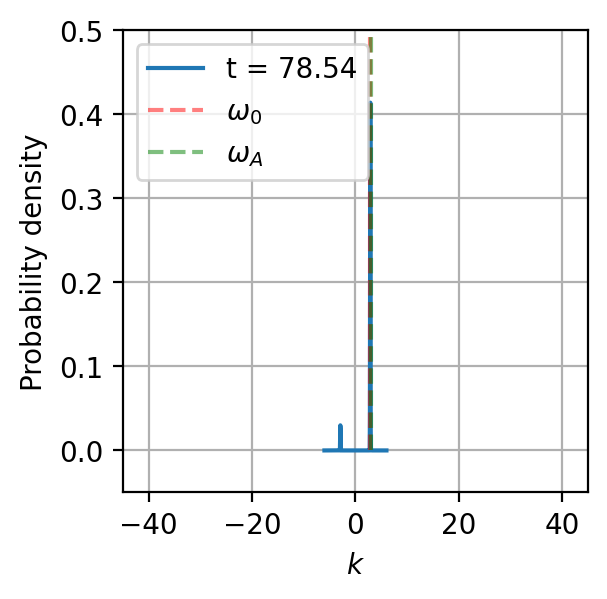

In [74]:
t_index = -1
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

#evolution of the probability density in position space
ax.plot(k_tab, N_k_t[:,t_index], label="t = {:.2f}".format(times[t_index]))
ax.set_xlim(-omega_max_axis, omega_max_axis)
ax.vlines(omega_0, 0, 1, color='r', linestyle='--', label=r'$\omega_0$', alpha=0.5)
ax.vlines(omega_A, 0, 1, color='g', linestyle='--', label=r'$\omega_A$', alpha=0.5)
ax.legend(loc='upper left')
ax.set_xlabel(r'$k$')   
ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('Probability density')

ax.grid()


plt.show()

<h1> UV Cut-off </h1>

Apparently, the UV cutoff has its importance ... let's check it

In [131]:
L = 80*pi
T = L/2
dt = 0.1
#number of atom
n_A = 1
x_A = 0

#width of the wave packet
sigma = L/8
x_0 = -L/4


#Jaynes-Cummings parameter g_0 and energies (supposed to have perfect reflection)
g_0 = 0.1
omega_A = 5
omega_0 = 4.95 #induce a small detuning

nb_freq = 30
omega_max_tab = np.linspace(2*omega_A, 15*omega_A, nb_freq)
reflection_tab = np.zeros(nb_freq)
transmission_tab = np.zeros(nb_freq)


for x in tqdm(range(nb_freq)):
    omega_max = omega_max_tab[x]
    _, k_tab, N_k_t, N_A_t,_  = get_data_mirror(L, T, dt, omega_0, omega_A, omega_max, n_A, g_0, x_A, sigma, x_0, print_nb_modes=True)

    n_modes = N_k_t.shape[0]
    R_current = 0
    T_current = 0
    for i in range(n_modes): 
        if k_tab[i] <= 0:
            R_current += N_k_t[i,-1]
        else:
            T_current += N_k_t[i,-1]
    reflection_tab[x] = R_current
    transmission_tab[x] = T_current

  0%|          | 0/30 [00:00<?, ?it/s]

Number of modes:  801
10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.38s. Est. time left: 00:00:00:00
40.0%. Run time:   0.52s. Est. time left: 00:00:00:00
50.0%. Run time:   0.77s. Est. time left: 00:00:00:00
60.0%. Run time:   0.95s. Est. time left: 00:00:00:00
70.0%. Run time:   1.11s. Est. time left: 00:00:00:00
80.0%. Run time:   1.26s. Est. time left: 00:00:00:00
90.0%. Run time:   1.41s. Est. time left: 00:00:00:00
100.0%. Run time:   1.55s. Est. time left: 00:00:00:00
Total run time:   1.56s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  979
10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.47s. Est. time left: 00:00:00:01
40.0%. Run time:   0.63s. Est. time left: 00:00:00:00
50.0%. Run time:   0.78s. Est. time left: 00:00:00:00
60.0%. Run time:   0.94s. Est. time left: 00:00:00:00
70.0%. Run time:   1.10s. Est. time left: 00:00:00:00
80.0%. Run time:   1.25s. Est. time left: 00:00:00:00
90.0%. Run time:   1.40s. Est. time left: 00:00:00:00
100.0%. Run time:   1.55s. Est. time left: 00:00:00:00
Total run time:   1.55s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  1159
10.0%. Run time:   0.27s. Est. time left: 00:00:00:02
20.0%. Run time:   0.56s. Est. time left: 00:00:00:02
30.0%. Run time:   0.86s. Est. time left: 00:00:00:02
40.0%. Run time:   1.10s. Est. time left: 00:00:00:01
50.0%. Run time:   1.34s. Est. time left: 00:00:00:01
60.0%. Run time:   1.58s. Est. time left: 00:00:00:01
70.0%. Run time:   1.86s. Est. time left: 00:00:00:00
80.0%. Run time:   2.10s. Est. time left: 00:00:00:00
90.0%. Run time:   2.34s. Est. time left: 00:00:00:00
100.0%. Run time:   2.59s. Est. time left: 00:00:00:00
Total run time:   2.59s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  1337
10.0%. Run time:   0.34s. Est. time left: 00:00:00:03
20.0%. Run time:   0.71s. Est. time left: 00:00:00:02
30.0%. Run time:   1.09s. Est. time left: 00:00:00:02
40.0%. Run time:   1.46s. Est. time left: 00:00:00:02
50.0%. Run time:   1.80s. Est. time left: 00:00:00:01
60.0%. Run time:   2.14s. Est. time left: 00:00:00:01
70.0%. Run time:   2.48s. Est. time left: 00:00:00:01
80.0%. Run time:   2.83s. Est. time left: 00:00:00:00
90.0%. Run time:   3.17s. Est. time left: 00:00:00:00
100.0%. Run time:   3.51s. Est. time left: 00:00:00:00
Total run time:   3.51s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  1517
10.0%. Run time:   0.75s. Est. time left: 00:00:00:06
20.0%. Run time:   1.50s. Est. time left: 00:00:00:05
30.0%. Run time:   2.03s. Est. time left: 00:00:00:04
40.0%. Run time:   2.61s. Est. time left: 00:00:00:03
50.0%. Run time:   3.18s. Est. time left: 00:00:00:03
60.0%. Run time:   3.85s. Est. time left: 00:00:00:02
70.0%. Run time:   4.55s. Est. time left: 00:00:00:01
80.0%. Run time:   5.21s. Est. time left: 00:00:00:01
90.0%. Run time:   5.85s. Est. time left: 00:00:00:00
100.0%. Run time:   6.44s. Est. time left: 00:00:00:00
Total run time:   6.44s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  1697
10.0%. Run time:   0.74s. Est. time left: 00:00:00:06
20.0%. Run time:   1.49s. Est. time left: 00:00:00:05
30.0%. Run time:   2.29s. Est. time left: 00:00:00:05
40.0%. Run time:   3.25s. Est. time left: 00:00:00:04
50.0%. Run time:   4.11s. Est. time left: 00:00:00:04
60.0%. Run time:   4.90s. Est. time left: 00:00:00:03
70.0%. Run time:   5.65s. Est. time left: 00:00:00:02
80.0%. Run time:   6.42s. Est. time left: 00:00:00:01
90.0%. Run time:   7.15s. Est. time left: 00:00:00:00
100.0%. Run time:   7.85s. Est. time left: 00:00:00:00
Total run time:   7.85s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  1875
10.0%. Run time:   0.74s. Est. time left: 00:00:00:06
20.0%. Run time:   1.52s. Est. time left: 00:00:00:06
30.0%. Run time:   2.48s. Est. time left: 00:00:00:05
40.0%. Run time:   3.29s. Est. time left: 00:00:00:04
50.0%. Run time:   4.48s. Est. time left: 00:00:00:04
60.0%. Run time:   5.75s. Est. time left: 00:00:00:03
70.0%. Run time:   7.05s. Est. time left: 00:00:00:03
80.0%. Run time:   8.25s. Est. time left: 00:00:00:02
90.0%. Run time:   9.60s. Est. time left: 00:00:00:01
100.0%. Run time:  10.89s. Est. time left: 00:00:00:00
Total run time:  10.89s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2055
10.0%. Run time:   0.99s. Est. time left: 00:00:00:08
20.0%. Run time:   2.28s. Est. time left: 00:00:00:09
30.0%. Run time:   3.43s. Est. time left: 00:00:00:07
40.0%. Run time:   5.00s. Est. time left: 00:00:00:07
50.0%. Run time:   6.55s. Est. time left: 00:00:00:06
60.0%. Run time:   8.10s. Est. time left: 00:00:00:05
70.0%. Run time:   9.63s. Est. time left: 00:00:00:04
80.0%. Run time:  11.19s. Est. time left: 00:00:00:02
90.0%. Run time:  12.75s. Est. time left: 00:00:00:01
100.0%. Run time:  14.29s. Est. time left: 00:00:00:00
Total run time:  14.29s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2235
10.0%. Run time:   1.21s. Est. time left: 00:00:00:10
20.0%. Run time:   2.65s. Est. time left: 00:00:00:10
30.0%. Run time:   4.42s. Est. time left: 00:00:00:10
40.0%. Run time:   6.31s. Est. time left: 00:00:00:09
50.0%. Run time:   8.11s. Est. time left: 00:00:00:08
60.0%. Run time:   9.80s. Est. time left: 00:00:00:06
70.0%. Run time:  11.64s. Est. time left: 00:00:00:04
80.0%. Run time:  14.02s. Est. time left: 00:00:00:03
90.0%. Run time:  16.72s. Est. time left: 00:00:00:01
100.0%. Run time:  19.30s. Est. time left: 00:00:00:00
Total run time:  19.31s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2413
10.0%. Run time:   1.46s. Est. time left: 00:00:00:13
20.0%. Run time:   3.52s. Est. time left: 00:00:00:14
30.0%. Run time:   5.41s. Est. time left: 00:00:00:12
40.0%. Run time:   7.36s. Est. time left: 00:00:00:11
50.0%. Run time:  10.24s. Est. time left: 00:00:00:10
60.0%. Run time:  13.15s. Est. time left: 00:00:00:08
70.0%. Run time:  15.91s. Est. time left: 00:00:00:06
80.0%. Run time:  18.61s. Est. time left: 00:00:00:04
90.0%. Run time:  21.30s. Est. time left: 00:00:00:02
100.0%. Run time:  24.14s. Est. time left: 00:00:00:00
Total run time:  24.14s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2593
10.0%. Run time:   1.83s. Est. time left: 00:00:00:16
20.0%. Run time:   3.62s. Est. time left: 00:00:00:14
30.0%. Run time:   5.71s. Est. time left: 00:00:00:13
40.0%. Run time:   7.94s. Est. time left: 00:00:00:11
50.0%. Run time:  10.35s. Est. time left: 00:00:00:10
60.0%. Run time:  13.47s. Est. time left: 00:00:00:08
70.0%. Run time:  16.66s. Est. time left: 00:00:00:07
80.0%. Run time:  19.76s. Est. time left: 00:00:00:04
90.0%. Run time:  22.87s. Est. time left: 00:00:00:02
100.0%. Run time:  26.03s. Est. time left: 00:00:00:00
Total run time:  26.04s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2773
10.0%. Run time:   2.38s. Est. time left: 00:00:00:21
20.0%. Run time:   4.84s. Est. time left: 00:00:00:19
30.0%. Run time:   7.50s. Est. time left: 00:00:00:17
40.0%. Run time:  10.99s. Est. time left: 00:00:00:16
50.0%. Run time:  14.55s. Est. time left: 00:00:00:14
60.0%. Run time:  18.10s. Est. time left: 00:00:00:12
70.0%. Run time:  21.65s. Est. time left: 00:00:00:09
80.0%. Run time:  25.20s. Est. time left: 00:00:00:06
90.0%. Run time:  28.74s. Est. time left: 00:00:00:03
100.0%. Run time:  32.15s. Est. time left: 00:00:00:00
Total run time:  32.15s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  2951
10.0%. Run time:   2.54s. Est. time left: 00:00:00:22
20.0%. Run time:   5.24s. Est. time left: 00:00:00:20
30.0%. Run time:   8.54s. Est. time left: 00:00:00:19
40.0%. Run time:  12.56s. Est. time left: 00:00:00:18
50.0%. Run time:  16.64s. Est. time left: 00:00:00:16
60.0%. Run time:  20.65s. Est. time left: 00:00:00:13
70.0%. Run time:  24.72s. Est. time left: 00:00:00:10
80.0%. Run time:  28.75s. Est. time left: 00:00:00:07
90.0%. Run time:  32.82s. Est. time left: 00:00:00:03
100.0%. Run time:  37.15s. Est. time left: 00:00:00:00
Total run time:  37.15s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  3131
10.0%. Run time:   3.38s. Est. time left: 00:00:00:30
20.0%. Run time:   8.73s. Est. time left: 00:00:00:34
30.0%. Run time:  14.97s. Est. time left: 00:00:00:34
40.0%. Run time:  23.44s. Est. time left: 00:00:00:35
50.0%. Run time:  32.00s. Est. time left: 00:00:00:31
60.0%. Run time:  40.42s. Est. time left: 00:00:00:26
70.0%. Run time:  48.98s. Est. time left: 00:00:00:20
80.0%. Run time:  58.87s. Est. time left: 00:00:00:14
90.0%. Run time:  67.59s. Est. time left: 00:00:00:07
100.0%. Run time:  76.16s. Est. time left: 00:00:00:00
Total run time:  76.16s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  3311
10.0%. Run time:   3.82s. Est. time left: 00:00:00:34
20.0%. Run time:   9.86s. Est. time left: 00:00:00:39
30.0%. Run time:  18.18s. Est. time left: 00:00:00:42
40.0%. Run time:  27.57s. Est. time left: 00:00:00:41
50.0%. Run time:  37.10s. Est. time left: 00:00:00:37
60.0%. Run time:  46.56s. Est. time left: 00:00:00:31
70.0%. Run time:  56.15s. Est. time left: 00:00:00:24
80.0%. Run time:  65.64s. Est. time left: 00:00:00:16
90.0%. Run time:  76.56s. Est. time left: 00:00:00:08
100.0%. Run time:  92.02s. Est. time left: 00:00:00:00
Total run time:  92.02s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  3489
10.0%. Run time:   5.05s. Est. time left: 00:00:00:45
20.0%. Run time:  13.96s. Est. time left: 00:00:00:55
30.0%. Run time:  25.88s. Est. time left: 00:00:01:00
40.0%. Run time:  36.06s. Est. time left: 00:00:00:54
50.0%. Run time:  46.36s. Est. time left: 00:00:00:46
60.0%. Run time:  56.48s. Est. time left: 00:00:00:37
70.0%. Run time:  70.56s. Est. time left: 00:00:00:30
80.0%. Run time:  86.49s. Est. time left: 00:00:00:21
90.0%. Run time: 102.53s. Est. time left: 00:00:00:11
100.0%. Run time: 119.42s. Est. time left: 00:00:00:00
Total run time: 119.42s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  3669
10.0%. Run time:   6.01s. Est. time left: 00:00:00:53
20.0%. Run time:  17.76s. Est. time left: 00:00:01:11
30.0%. Run time:  29.72s. Est. time left: 00:00:01:09
40.0%. Run time:  40.96s. Est. time left: 00:00:01:01
50.0%. Run time:  52.40s. Est. time left: 00:00:00:52
60.0%. Run time:  70.11s. Est. time left: 00:00:00:46
70.0%. Run time:  87.77s. Est. time left: 00:00:00:37
80.0%. Run time: 105.25s. Est. time left: 00:00:00:26
90.0%. Run time: 123.77s. Est. time left: 00:00:00:13
100.0%. Run time: 142.59s. Est. time left: 00:00:00:00
Total run time: 142.59s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  3849
10.0%. Run time:   8.08s. Est. time left: 00:00:01:12
20.0%. Run time:  20.65s. Est. time left: 00:00:01:22
30.0%. Run time:  33.00s. Est. time left: 00:00:01:16
40.0%. Run time:  45.35s. Est. time left: 00:00:01:08
50.0%. Run time:  63.94s. Est. time left: 00:00:01:03
60.0%. Run time:  83.24s. Est. time left: 00:00:00:55
70.0%. Run time: 102.83s. Est. time left: 00:00:00:43
80.0%. Run time: 122.22s. Est. time left: 00:00:00:30
90.0%. Run time: 141.79s. Est. time left: 00:00:00:15
100.0%. Run time: 160.99s. Est. time left: 00:00:00:00
Total run time: 160.99s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4027
10.0%. Run time:   8.64s. Est. time left: 00:00:01:17
20.0%. Run time:  21.95s. Est. time left: 00:00:01:27
30.0%. Run time:  35.77s. Est. time left: 00:00:01:23
40.0%. Run time:  53.60s. Est. time left: 00:00:01:20
50.0%. Run time:  75.82s. Est. time left: 00:00:01:15
60.0%. Run time:  98.79s. Est. time left: 00:00:01:05
70.0%. Run time: 123.75s. Est. time left: 00:00:00:52
80.0%. Run time: 146.48s. Est. time left: 00:00:00:36
90.0%. Run time: 172.26s. Est. time left: 00:00:00:19
100.0%. Run time: 196.53s. Est. time left: 00:00:00:00
Total run time: 196.53s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4207
10.0%. Run time:  10.05s. Est. time left: 00:00:01:30
20.0%. Run time:  25.22s. Est. time left: 00:00:01:40
30.0%. Run time:  41.38s. Est. time left: 00:00:01:36
40.0%. Run time:  64.70s. Est. time left: 00:00:01:37
50.0%. Run time:  87.74s. Est. time left: 00:00:01:27
60.0%. Run time: 111.16s. Est. time left: 00:00:01:14
70.0%. Run time: 134.07s. Est. time left: 00:00:00:57
80.0%. Run time: 157.50s. Est. time left: 00:00:00:39
90.0%. Run time: 180.64s. Est. time left: 00:00:00:19
100.0%. Run time: 203.45s. Est. time left: 00:00:00:00
Total run time: 203.45s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4387
10.0%. Run time:  11.04s. Est. time left: 00:00:01:38
20.0%. Run time:  26.18s. Est. time left: 00:00:01:44
30.0%. Run time:  49.02s. Est. time left: 00:00:01:54
40.0%. Run time:  71.85s. Est. time left: 00:00:01:47
50.0%. Run time:  94.76s. Est. time left: 00:00:01:34
60.0%. Run time: 117.51s. Est. time left: 00:00:01:18
70.0%. Run time: 140.56s. Est. time left: 00:00:01:00
80.0%. Run time: 163.40s. Est. time left: 00:00:00:40
90.0%. Run time: 193.68s. Est. time left: 00:00:00:21
100.0%. Run time: 229.40s. Est. time left: 00:00:00:00
Total run time: 229.40s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4565
10.0%. Run time:  11.90s. Est. time left: 00:00:01:46
20.0%. Run time:  32.85s. Est. time left: 00:00:02:11
30.0%. Run time:  54.70s. Est. time left: 00:00:02:07
40.0%. Run time:  76.34s. Est. time left: 00:00:01:54
50.0%. Run time: 102.82s. Est. time left: 00:00:01:42
60.0%. Run time: 137.02s. Est. time left: 00:00:01:31
70.0%. Run time: 171.06s. Est. time left: 00:00:01:13
80.0%. Run time: 205.02s. Est. time left: 00:00:00:51
90.0%. Run time: 239.26s. Est. time left: 00:00:00:26
100.0%. Run time: 273.18s. Est. time left: 00:00:00:00
Total run time: 273.18s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4745
10.0%. Run time:  13.31s. Est. time left: 00:00:01:59
20.0%. Run time:  33.16s. Est. time left: 00:00:02:12
30.0%. Run time:  61.81s. Est. time left: 00:00:02:23
40.0%. Run time:  90.15s. Est. time left: 00:00:02:15
50.0%. Run time: 118.90s. Est. time left: 00:00:01:58
60.0%. Run time: 147.46s. Est. time left: 00:00:01:38
70.0%. Run time: 176.15s. Est. time left: 00:00:01:15
80.0%. Run time: 207.52s. Est. time left: 00:00:00:51
90.0%. Run time: 252.19s. Est. time left: 00:00:00:27
100.0%. Run time: 296.48s. Est. time left: 00:00:00:00
Total run time: 296.48s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  4925
10.0%. Run time:  12.95s. Est. time left: 00:00:01:56
20.0%. Run time:  35.29s. Est. time left: 00:00:02:21
30.0%. Run time:  66.16s. Est. time left: 00:00:02:34
40.0%. Run time:  96.83s. Est. time left: 00:00:02:25
50.0%. Run time: 128.06s. Est. time left: 00:00:02:07
60.0%. Run time: 158.72s. Est. time left: 00:00:01:45
70.0%. Run time: 189.72s. Est. time left: 00:00:01:21
80.0%. Run time: 236.73s. Est. time left: 00:00:00:59
90.0%. Run time: 285.17s. Est. time left: 00:00:00:31
100.0%. Run time: 333.12s. Est. time left: 00:00:00:00
Total run time: 333.12s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  5103
10.0%. Run time:  16.29s. Est. time left: 00:00:02:25
20.0%. Run time:  44.43s. Est. time left: 00:00:02:57
30.0%. Run time:  76.95s. Est. time left: 00:00:02:59
40.0%. Run time: 109.02s. Est. time left: 00:00:02:43
50.0%. Run time: 141.36s. Est. time left: 00:00:02:21
60.0%. Run time: 181.41s. Est. time left: 00:00:02:00
70.0%. Run time: 232.26s. Est. time left: 00:00:01:39
80.0%. Run time: 282.67s. Est. time left: 00:00:01:10
90.0%. Run time: 333.79s. Est. time left: 00:00:00:36
100.0%. Run time: 384.02s. Est. time left: 00:00:00:00
Total run time: 384.02s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  5283
10.0%. Run time:  18.17s. Est. time left: 00:00:02:42
20.0%. Run time:  50.72s. Est. time left: 00:00:03:22
30.0%. Run time:  85.25s. Est. time left: 00:00:03:18
40.0%. Run time: 119.55s. Est. time left: 00:00:02:59
50.0%. Run time: 160.48s. Est. time left: 00:00:02:40
60.0%. Run time: 213.78s. Est. time left: 00:00:02:22
70.0%. Run time: 267.77s. Est. time left: 00:00:01:54
80.0%. Run time: 321.15s. Est. time left: 00:00:01:20
90.0%. Run time: 374.96s. Est. time left: 00:00:00:41
100.0%. Run time: 428.29s. Est. time left: 00:00:00:00
Total run time: 428.29s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  5463
10.0%. Run time:  10.46s. Est. time left: 00:00:01:33
20.0%. Run time:  20.80s. Est. time left: 00:00:01:23
30.0%. Run time:  31.31s. Est. time left: 00:00:01:12
40.0%. Run time:  41.67s. Est. time left: 00:00:01:02
50.0%. Run time:  52.16s. Est. time left: 00:00:00:52
60.0%. Run time:  62.59s. Est. time left: 00:00:00:41
70.0%. Run time:  73.20s. Est. time left: 00:00:00:31
80.0%. Run time:  83.57s. Est. time left: 00:00:00:20
90.0%. Run time:  94.02s. Est. time left: 00:00:00:10
100.0%. Run time: 104.41s. Est. time left: 00:00:00:00
Total run time: 104.41s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  5641
10.0%. Run time:  20.84s. Est. time left: 00:00:03:06
20.0%. Run time:  61.25s. Est. time left: 00:00:04:04
30.0%. Run time: 101.14s. Est. time left: 00:00:03:55
40.0%. Run time: 141.59s. Est. time left: 00:00:03:32
50.0%. Run time: 204.14s. Est. time left: 00:00:03:23
60.0%. Run time: 266.51s. Est. time left: 00:00:02:57
70.0%. Run time: 330.44s. Est. time left: 00:00:02:21
80.0%. Run time: 392.74s. Est. time left: 00:00:01:38
90.0%. Run time: 455.59s. Est. time left: 00:00:00:50
100.0%. Run time: 517.77s. Est. time left: 00:00:00:00
Total run time: 517.78s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  5821
10.0%. Run time:  25.74s. Est. time left: 00:00:03:50
20.0%. Run time:  68.13s. Est. time left: 00:00:04:32
30.0%. Run time: 110.77s. Est. time left: 00:00:04:17
40.0%. Run time: 167.93s. Est. time left: 00:00:04:11
50.0%. Run time: 237.92s. Est. time left: 00:00:03:57
60.0%. Run time: 307.93s. Est. time left: 00:00:03:25
70.0%. Run time: 377.81s. Est. time left: 00:00:02:41
80.0%. Run time: 444.69s. Est. time left: 00:00:01:51
90.0%. Run time: 510.83s. Est. time left: 00:00:00:56
100.0%. Run time: 576.91s. Est. time left: 00:00:00:00
Total run time: 576.91s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

Number of modes:  6001
10.0%. Run time:  31.21s. Est. time left: 00:00:04:39
20.0%. Run time:  73.06s. Est. time left: 00:00:04:52
30.0%. Run time: 126.98s. Est. time left: 00:00:04:55
40.0%. Run time: 192.08s. Est. time left: 00:00:04:48
50.0%. Run time: 257.65s. Est. time left: 00:00:04:17
60.0%. Run time: 323.17s. Est. time left: 00:00:03:35
70.0%. Run time: 389.38s. Est. time left: 00:00:02:46
80.0%. Run time: 454.55s. Est. time left: 00:00:01:53
90.0%. Run time: 520.09s. Est. time left: 00:00:00:57
100.0%. Run time: 585.37s. Est. time left: 00:00:00:00
Total run time: 585.37s
Computing occupation numbers in momentum space...


  0%|          | 0/1256 [00:00<?, ?it/s]

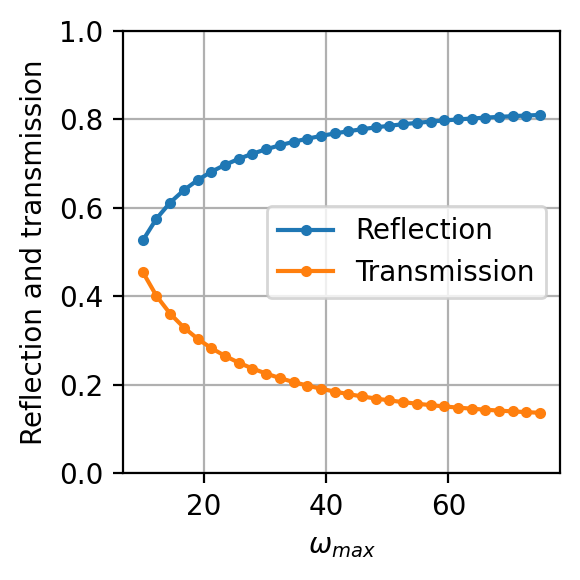

In [132]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(omega_max_tab, reflection_tab, markersize=3, marker='o', label='Reflection')
ax.plot(omega_max_tab, transmission_tab, markersize=3, marker='o', label='Transmission')
ax.set_xlabel(r'$\omega_{max}$')
ax.set_ylabel("Reflection and transmission")
ax.grid()
ax.legend()
ax.set_ylim(0, 1)

fig.tight_layout()
plt.show()